# Bag of Words Meets Bags of Popcorn : Word2Vec

## Table of Contents

1. [Introduction](#intro)<br><br>
2. [Reading the Data](#reading)<br><br>
3. [Data Cleaning and Text Preprocessing](#preprocess)<br> - [3.1. Removing HTML Markup by using BeautifulSoup Package](#beauti)<br> - [3.2. Removing Non-Letter Characters & Converting Reviews to Lower Case](#non-char)<br> - [3.3. Tokenization](#token)<br> -  [3.4. Removing Stop words](#stop)<br> - [3.5. Stemming / Lemmatization](#stml)<br> - [3.6. Putting It All Together](#together)<br><br>

4. [Visualization](#visu)<br>- [4.1. WordCloud](#wc) <br>- [4.2. Distribution](#dist)<br><br>
5. [Bag of Words](#bag)<br><br>
6. [Modeling](#modeling)<br>- [6.1. Support Vector Machine](#svm)<br>- [6.2. Gaussian Naive Bayes Classifier](#gnb)<br>- [6.3. Bernoulli Naive Bayes Classifier](#bnb)<br>- [6.4. XG Boost](#xgb)<br><br>
7. [Submission](#submission)<br>

## 1. Introduction <a id = "intro"></a>

In this notebook, for a bit deeper sentiment analysis, we will be using Word2Vec to train a model. Word2Vec is a neural network based algorithm that creates distributed word vectors.
One of the advantages of Word2Vec over Bag Of Words, it understands meaning and semantic relationships among words. Also, it does not require labels in order to create meaningful representations. In addition that in a aspect of speed, it learns quickly compared to other methods. Once the Word2Vec is created, we will visualize the vectorized data by t-SNE. Before we dive into modeling, there is one more step to prepare two different matrices created by using Word2Vec by vector averaging method and clustering method. We will test them independently and choose the best one among the results predicted by different methods including 'bag of words'.

## 1. Reading the Data <a id = "reading"></a>

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the labeled training and test data
# Header = 0 indicates that the first line of the file contains column names, 
# delimiter = \t indicates that the fields are seperated by tabs, and 
# quoting = 3 tells python to ignore doubled quotes

train = pd.read_csv('labeledTrainData.tsv', header = 0, delimiter = '\t', quoting = 3)
test = pd.read_csv('testData.tsv', header = 0, delimiter = '\t', quoting = 3)
unlabel_train = pd.read_csv('unlabeledTrainData.tsv', header = 0, delimiter = '\t', quoting = 3)

In [3]:
'train dim:{}, unlabeled train dim:{}, test dim:{}'.format(train.shape, unlabel_train.shape, test.shape)

'train dim:(25000, 3), unlabeled train dim:(50000, 2), test dim:(25000, 2)'

One thing to notice is that now we can use a unlabeled data set since as mentioned to the introduction, word2vec can learn from unlabeled data.

## 2. Data Cleaning and Text Preprocessing 


In [4]:
# Import the libraries for data cleaning.

from bs4 import BeautifulSoup
import re
import nltk

### 2.1 Splitting a Sentence to Words

In [80]:
def preprocess_wordlist(data, stopwords = False):
    
    # Remove HTML tag
    review = BeautifulSoup(data,'html.parser').get_text()
    
    # Remove non-letters
    review = re.sub('[^a-zA-Z]', ' ', review)
    
    # Convert to lower case
    review = review.lower()
    
    # Tokenize
    word = nltk.word_tokenize(review)
    
    # Optional: Remove stop words (false by default)
    if stopwords:
        stops = set(nltk.corpus.stopwords.words("english"))
        
        words = [w for w in word if not w in stops]
    
    return word


For creating a model, unlike Bag Of Words method, it is not necessary to remove the stopwords such as "the", "a", "and", etc as the algorithm relies on the broader context of the sentence in order to produce high-quality word vectors. Another thing to mention is that it may improve the accuracy to keep numbers from the data but for the simplicity, I decide to delete everything except alphabet characters.

### 2.2 Splitting a Paragraph to Sentences

In [75]:
#tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def preprocess_sent(data, stopwords = False):
    
    # Split the paragraph into sentences
    
    #raw = tokenizer.tokenize(data.strip())
    raw = nltk.sent_tokenize(data.strip())
    
    # If the length of the sentence is greater than 0, plug the sentence in the function preprocess_wordlist (clean the sentence)
    sentences = [preprocess_wordlist(sent, stopwords) for sent in raw if len(sent) > 0]
    
    return sentences



The most important thing to notice is splitting sentences by sentences __prior to__ splitting them to single word because you will lose the information which words have formed a sentence if you split into words first. Some may question that simple split function might be enough to split up a paragraph to sentences; however, English sentences can end with many punctuations and it is not strange that anything can be placed at the end of the sentences. For this reason, when we split text into sentences, we need to use NLTK's punkt tokenizer (sent_tokenize function uses an instance of a punkt tokenizer). The punkt tokenizer is an unsupervised trainable model ,which enables that the tokenizer uses to decide where to cut or learn abbreviations in text.

### 2.3 Combining Labeled and Unlabeled Reviews

In [7]:
sentence = []

for review in train['review']:
    sentence += preprocess_sent(review)
    
for review in unlabel_train['review']:
    sentence += preprocess_sent(review)


In [118]:
print(len(sentence))
print()
print(sentence[:2])

795538

[['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again'], ['maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent']]


In [119]:
train['review'][0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

## 3. Word2Vec

In general, there are two type of architecture options: skip-gram (default) and CBOW (continuous bag of words). Most of time, skip-gram is little bit slower but has more accuracy than CBOW. CBOW is the method to predict one word by whole text; therefore, small set of data is more favorable. On the other hand, skip-gram is totally opposite to CBOW. With the target word, skip-gram is the method to predict the words around the target words. The more data we have, the better it performs. As the architecture, there are two training algorithms for Word2Vec: Hierarchical softmax (default) and negative sampling. We will be using the default.

In [9]:
from gensim.models import word2vec

In [20]:
features = 400
min_count = 40
num_processor = 4
context = 10
downsampling = 0.001

In [21]:
model = word2vec.Word2Vec(sentence, workers = num_processor, 
                         size = features, min_count = min_count,
                         window = context, sample = downsampling)

Worker threads : Number of parallel processes to run. One thing to remember here is that unlike sklearn, it does not accept -1 option to use all the processors. <br>

Downsampling of frequent words : According to the Google documentation, values between 0.00001 and 0.001 would suffice. <br>

Context : How many words around the target word will be used? <br>

Minimum word count: This helps limit the size of the vocabulary to meaningful words. Any word that does not occur at least this many times across all documents is ignored. Reasonable values could be between 10 and 100. The reason why I chose 40 is that there are 30 reviews in each movie and repeat the title 30 times; therefore in order to avoid attaching too much importance to individual movie titles, I set to 40. <br>

Word vector dimensionality: Self-explanatory. 


In [22]:
# Unload unneccessary memory once the learning process is done.

model.init_sims(replace = True)

In [23]:
model_name = "400features_40minwords_20context"
model.save(model_name)

In [27]:
model.most_similar("king")

[('prince', 0.6210002899169922),
 ('lion', 0.6161816120147705),
 ('kingdom', 0.5578585863113403),
 ('dorff', 0.5542510747909546),
 ('stephen', 0.5515279769897461),
 ('aladdin', 0.5411050319671631),
 ('kings', 0.5334075689315796),
 ('ruler', 0.5261061787605286),
 ('arthur', 0.5151311159133911),
 ('solomon', 0.5070411562919617)]

## 4. Visualization

As the Word2Vec has more than two features, it is hard to directly plot the whole data. We will be using the technique called t-SNE so that we can reduce the dimensions from 400 to 2, which enables to visualize more human-friendly and see the relationship among points (words).

In [36]:
# Import libraries
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt

In [43]:
# List of vocabulary.

vocab = list(model.wv.vocab)
X = model[vocab]

print("Total Number of Vocab:", len(X))
print()
print(X[0][:10])

# Visualize only 100 words.

tsne = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X[:100,:])

Total Number of Vocab: 16487
[ 0.05575439 -0.05088685 -0.01745298  0.08512761  0.10888057  0.06085049
  0.12595093  0.01123416  0.0527401  -0.03852392]


In [42]:
df = pd.DataFrame(X_tsne, index = vocab[:100], columns = ['X','Y'])
df.head()

,X,Y
with,7.052106,7.486159
all,7.790519,3.072140
this,3.778893,1.668488
stuff,1.669798,1.578719
going,1.472836,-1.528923


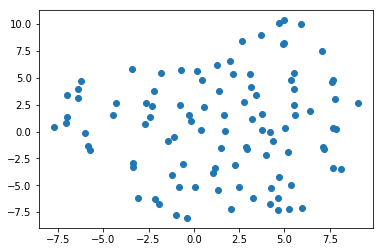

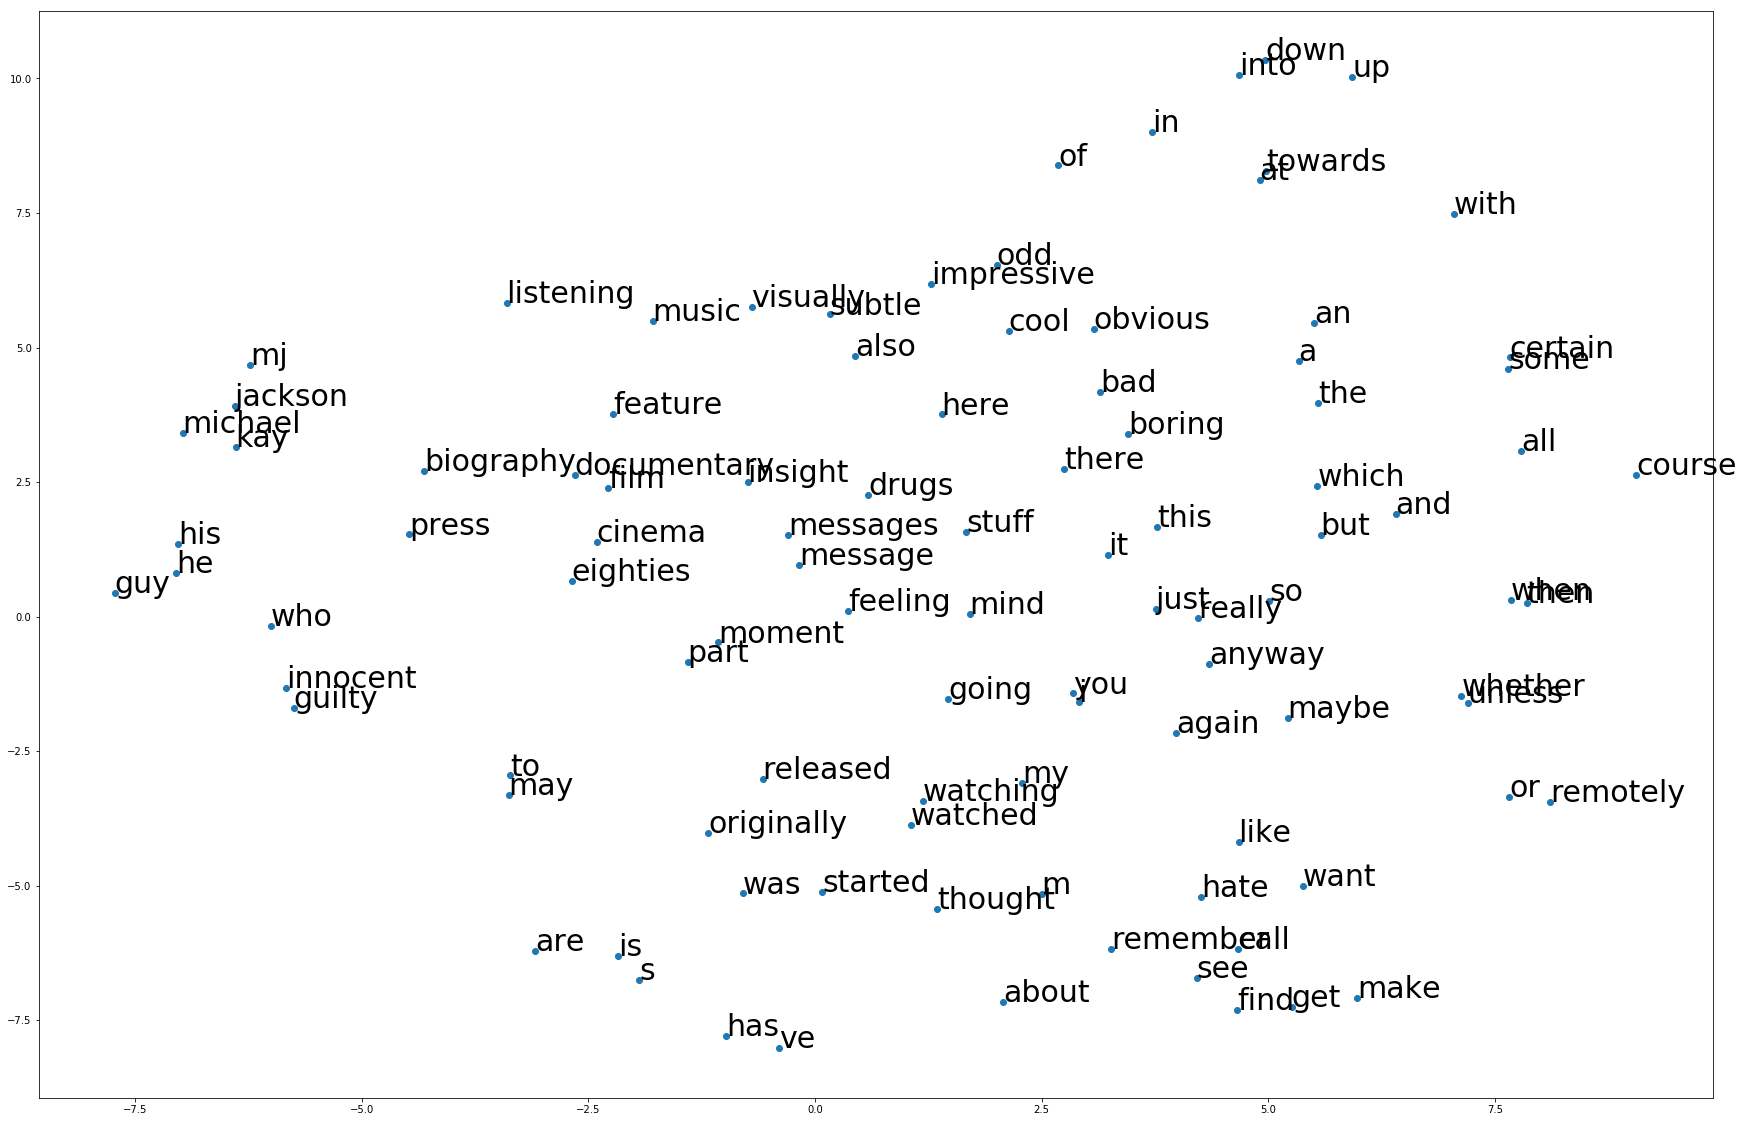

In [50]:
fig = plt.figure()
fig.set_size_inches(30,20)

ax = fig.add_subplot(1,1,1)
ax.scatter(df['X'], df['Y'])

# Put the label on each point.
for word, pos in df.iterrows():
    ax.annotate(word, pos, fontsize = 30)
plt.show()

## 5. From Words to Paragraph

### 5.1 Vector Averaging

In [120]:
''' 

The purpose of this function is to combine all the word2vec vector values of each word in each review
if each review is given as input and divide by the total number of words.

Each word can be represented as number of feature dimension space vector. ex) model['flower'] = array([0.1, 0.2, ...]).
(You can think of it as extended xy coordinate.) Therefore, it enables vectorizing each review by 
combining all the words' vector values.

Illustration example:

'I' = [0.1, 0.2, ...]
'have' = [0.2, 0.3, ...]
'a car' = [0.1, 0.2, ...]
'I have a car' = [0.1 + 0.2 + 0.1, 0.2 + 0.3 + 0.2,  ...]


ex) review1 = ['he', 'has', 'a', 'cat']

First word : If the word 'he' is in the word2vec, index the vector values from word2vec model by model['he']
(the dimension of the matrix would be, in this case, (400,) ) and add them to predefined zero matrix.

Second word: Check if there is the word 'has' in the word2vec model and if there is, index the vector values and 
add them on top of the added vector values from the first word.

The rest: Iterate the above steps for the rest of words and lastly, divide by the total number of words. 

Illustration example: 

zero : [0,    0,   0,   ....]
word1: [0.2,  0.3, 0.4, ....]
word2: [0.1,  0.2, 0.3, ....]

word(1~2): [0.3, 0.5, 0.7, ....]

'''

def makeFeatureVec(review, model, num_features):
    
    featureVec = np.zeros((num_features,), dtype = "float32")
    
    word_index = set(model.wv.index2word)
    nword = 0
    
    for word in review:
        if word in word_index:
            nword += 1
            featureVec = np.add(featureVec, model[word])
    
    featureVec = np.divide(featureVec, nword)        
    
    return featureVec

In [121]:
''' 

While iterating over reviews, add the vector sums of each review from the function "makeFeatureVec" to 
the predefined vector whose size is the number of total reviews and the number of features in word2vec.
The working principle is basically same with "makeFeatureVec" but this is a review basis and 
makeFeatureVec is word basis (or each word's vector basis)


return matrix:

            'ab'    'abba'    'bab'   'cat'
review 1    0.1      0.2     0.1       0.5
review 2    0.5      0.4     0.05      0.05
'''

def getAvgFeatureVec(clean_reviews, model, num_features):
    
    review_th = 0
    
    reviewFeatureVecs = np.zeros((len(clean_reviews), num_features), dtype = "float32")
    
    for review in clean_reviews:
        reviewFeatureVecs[int(review_th)] = makeFeatureVecs(review, model, num_features)
        review_th += 1
    
    return reviewFeatureVecs

In [122]:
clean_train_reviews = []

for review in train["review"]:
    clean_train_reviews.append(preprocess_wordlist(review, stopwords = True))

trainDataAvg = getAvgFeatureVec(clean_train_reviews, model, num_features)
    
    
clean_test_reviews = []

for review in test["review"]:
    clean_test_reviews.append(preprocess_wordlist(review, stopwords = True))

testDataAvg = getAvgFeatureVec(clean_test_reviews, model, num_features)

KeyboardInterrupt: 

Notice that we use stop word removal, which would just add noise.

We will compare the performance of vector averaging method and the next method 

### 5.2 Clustering

Word2Vec creates clusters of semantically related words, so we can try to use the similarity of words within a cluster. To achieve this, we will be using one of the most commonly used clustering technique called K-Means.

In [129]:
from sklearn.cluster import KMeans
import time

#### 5.2.1 KMeans Clustering

In [130]:
num_clusters = model.wv.syn0.shape[0] // 5

Why did we choose 5 clusters? <br>
Trial and error suggested that small clusters, with an average of only 5 words or so per cluster, gave better results than large clusters with many words. Feel free to change it to improve the score.

In [ ]:
start = time.time()

kmean = KMeans(n_clusters = num_clusters)
index = kmean.fit_predict(model.wv.syn0)

end = time.time()
print("Time taken for K-Means clustering: ", end - start, "seconds.")

word2vec's each row represents each word appeared in data after cleaning process. The column represents each variable of vector value. In other word, words * features matrix.

#### 5.2.2 Mapping Vocabulary to Cluster 

In [ ]:
index = list(index)
voca_list = model.wv.index2word

# dictionary format -  word : the cluster belongs to the key word.
voca_cluster = {voca_list[cluster]: index[cluster] for cluster in range(len(voca_list))}

Check whether the clustering model that we created works by printing words belongs to first ten clusters

In [136]:
# Check the first 10 clusters in voca_cluster we created.

for i in range(10):
    
    word = []
    
    for cluster in range(len(voca_cluster.values())):
        if(list(voca_cluster.values())[cluster] == i):
            word.append(list(voca_cluster.keys())[cluster])
    
    print(word)

NameError: name 'index' is not defined

#### 5.2.3 Bag of Centroids

In [ ]:
# Preprocess data for input as before

train_review = []

for review in train['review']:
    train_review.append(preprocess_wordlist(review, stopwords= True))

test_review = []

for review in test['review']:
    test_review.append(preprocess_wordlist(review, stopwords = True))

In [ ]:
train_centroid = np.zeros(len(train['review']), num_clusters, dtype = 'float32')
test_centroid = np.zeros(len(test['review']), num_clusters, dtype = 'float32')

In [141]:
'''
The array that we are going to create looks like this:

cl1 cl2 cl3 cl4 ....
 3   10  5   30 ...

As usual we will be creating the empty array having the number of clusters dimension space.
While Iterating over words, if there is any word found in the voca_cluster, find the cluster where the word belongs to
and add one to the feature corresponding to the cluster.

( ex) if 'cat' assigned to cluster 10 then add one to 10th feature in the empty array. )  

'''

def create_boc(wordlist, voca_cluster):
    
    # The number of cluster == the maximum number of values in voca_cluster
    boc = np.zeros(max(voca_cluster.values()) + 1, dtype='float32')
    
    # Iterate over words and increase by one to the cluster if any word in the voca_cluster we created
    for word in wordlist:
        if word in voca_cluster:
            index = voca_cluster[word]
            boc[index] += 1
            
    return boc
    

25000

In [145]:
# Transform the training and test set reviews into bags of centroid.

count = 0

for review in train_review:
    train_centroid[count] = create_boc(review, voca_cluster)
    count += 1
    
count = 0

for review in test_review:
    test_centroid[count] = create_boc(review, voca_cluster)
    count += 1
    

hi


## 6. Modeling

We will be evaluating below algorithms' cross validation means and errors. 

- Gaussian Naive Bayes 
- Bernoulli Naive Bayes
- Support Vector Machine
- Random Forest
- XG Boost

In [151]:
# Import libraries.

from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from mlxtend.classifier import StackingClassifier
from xgboost import XGBClassifier
from nltk.classifiy import maxent

from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve

In [ ]:
kfold = StratifiedKFold(n_splits=10, random_state = 2018)

### 6.1 Modeling for Vector Averaging

#### 6.11 Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(trainDataAvg, train['sentiment'])

In [ ]:
y_submission = gnb.predict(testDataAvg)

#### 6.12 Bernoulli Naive Bayes

In [ ]:
bnb = BernoulliNB()
gs_bnb = GridSearchCV(bnb, param_grid = {'alpha': np.linspace(0.1,2,11),
                                         'binarize': np.linspace(0.1,1,10)}, verbose = 1, cv = kfold, n_jobs = -1, scoring = "accuracy")
gs_bnb.fit(trainDataAvg, train['sentiment'])
gs_bnb_best = gs_bnb.best_estimator_
print(gs_bnb.best_params_)

In [ ]:
y_submission = gs_bnb.predict(testDataAvg)

In [167]:
np.linspace(0.1,1,10)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

#### 6.13 Support Vector Machine

In [ ]:
# LinearSVC

sv = LinearSVC(random_state=2018)

param_grid = {
    'class_weight':[{1:1}, {1:2}, 'balanced'],
    'C': [0.01, 0.05, 0.1, 0.5, 1, 10, 30],
    'penalty':['l1','l2']
}

gs_sv = GridSearchCV(sv, param_grid = param_grid, verbose = 1, cv = kfold, n_jobs = -1, scoring = "accuracy" )
gs_sv.fit(trainDataAvg, train['sentiment'])
gs_sv_best = gs_sv.best_estimator_
print(gs_sv.best_params_)

In [ ]:
y_submission = gs_sv.predict(testDataAvg)

In [158]:
# SVM

gammas = ['auto',0.1, 0.5, 1, 5, 10, 50]
Cs = [0.1,0.5,1,5,10,50]
weight = [{1:1}, {1:2}, 'balanced']
kernels = ['sigmoid','rbf']

param_grid = dict(C=Cs,gamma=gammas,class_weight=weight, kernel=kernels)
gsSVMC = GridSearchCV(SVC(probability=True, random_state = 2018),param_grid=param_grid,cv=kfold,scoring="accuracy",n_jobs=-1,verbose=1)
gsSVMC.fit(trainDataAvg, train['sentiment'])
gsSVMC_best = gsSVMC.best_estimator_
print(gsSVMC.best_params_)


NameError: name 'kfold' is not defined

In [162]:
y_submission = gsSVMC.predict(testDataAvg)

array([0, 1, 2])

#### 6.14 XG Boost

In [ ]:
XGB = XGBClassifier(random_state = 2018)

xg_param_grid = {
              'min_child_weight':[0.5,0.7,1,1.2],
              'n_estimators' : [100,300,500,1000,1500],
              'learning_rate': [0.2,0.1, 0.05, 0.01,0.001],
              'max_depth': [3,5,7,9,11],
              'subsample':[0.3,0.4,0.5,0.7,0.9],
              'colsample_bytree':[0.5,0.6,0.7,0.8,0.9]
              }
                
gsXGB = GridSearchCV(XGB,param_grid = xg_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsXGB.fit(trainDataAvg, train['sentiment'])
XGB_best = gsXGB.best_estimator_
print(gsXGB.best_params_)

In [ ]:
y_submission = gsXGB.predict(testDataAvg)

#### 6.15 Stacking

In [ ]:
# Not cleaned yet

XGB = XGBClassifier(random_state = 2018)

ExtC = ExtraTreesClassifier(random_state = 2018)
RFC = RandomForestClassifier(random_state = 2018)
SVMC = SVC(probability=True, random_state = 2018)

stack = StackingClassifier(classifiers = [ExtC, RFC, SVMC], meta_classifier = XGB)

params = {
              'meta-xgbclassifier__n_estimators' : [200, 220, 230, 240, 250, 252, 253],
              'meta-xgbclassifier__learning_rate': [1.5,1.0,0.99,0.98],
              'meta-xgbclassifier__max_depth': [1,2,3],
              
              'randomforestclassifier__max_depth':[7],
              'randomforestclassifier__max_features':[31],
              'randomforestclassifier__min_samples_leaf':[8],
              'randomforestclassifier__n_estimators':[349],
    
              "extratreesclassifier__max_depth": [6],
              "extratreesclassifier__max_features": ['auto'],
              "extratreesclassifier__min_samples_leaf": [1],
              "extratreesclassifier__n_estimators" :[360],
              "extratreesclassifier__bootstrap":[True],
    
              'svc__gamma': [0.012],
              'svc__class_weight': ['balanced',{1:1}],
              'svc__C':[0.15],
              'svc__kernel':['sigmoid','rbf']

        }

grid = GridSearchCV(estimator = stack, param_grid=params,cv=kfold,refit=True, scoring="accuracy", n_jobs= -1, verbose = 1)
grid.fit(X_train, y)
grid_best = grid.best_estimator_
print(grid_best)



### 6.2 Modeling for Clustering

#### 6.21 Gaussian Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(train_centroid, train['sentiment'])

In [ ]:
y_submission = gnb.predict(test_centroid)

#### 6.22 Bernoulli Naive Bayes

In [ ]:
bnb = BernoulliNB()
gs_bnb = GridSearchCV(bnb, param_grid = {'alpha': np.linspace(0.1,2,0.1), 'binarize': np.linspace(0.1,1,0.1)}, verbose = 1, cv = kfold, n_jobs = -1, scoring = "accuracy")
gs_bnb.fit(train_centroid, train['sentiment'])
gs_bnb_best = gs_bnb.best_estimator_
print(gs_bnb.best_params_)

In [ ]:
y_submission = gs_bnb.predict(test_centroid)

#### 6.23 Support Vector Machine

In [ ]:
# LinearSVC

sv = LinearSVC(random_state=2018)

param_grid = {
    'class_weight':[{1:1}, {1:2}, 'balanced'],
    'C': [0.01, 0.05, 0.1, 0.5, 1, 10, 30],
    'penalty':['l1','l2']
}

gs_sv = GridSearchCV(sv, param_grid = param_grid, verbose = 1, cv = kfold, n_jobs = -1, scoring = "accuracy" )
gs_sv.fit(train_centroid, train['sentiment'])
gs_sv_best = gs_sv.best_estimator_
print(gs_sv.best_params_)

In [ ]:
y_submission = gs_sv.predict(test_centroid)

In [ ]:
# SVM

gammas = ['auto',0.1, 0.5, 1, 5, 10, 50]
Cs = [0.1,0.5,1,5,10,50]
weight = [{1:1}, {1:2}, 'balanced']
kernels = ['sigmoid','rbf']

param_grid = dict(C=Cs,gamma=gammas,class_weight=weight, kernel=kernels)
gsSVMC = GridSearchCV(SVC(probability=True, random_state = 2018),param_grid=param_grid,cv=kfold,scoring="accuracy",n_jobs=-1,verbose=1)
gsSVMC.fit(train_centroid, train['sentiment'])
gsSVMC_best = gsSVMC.best_estimator_
print(gsSVMC.best_params_)



In [ ]:
y_submission = gsSVMC.predict(test_centroid)

#### 6.24 XG Boost

In [ ]:
XGB = XGBClassifier(random_state = 2018)

xg_param_grid = {
              'min_child_weight':[0.5,0.7,1,1.2],
              'n_estimators' : [100,300,500,1000,1500],
              'learning_rate': [0.2,0.1, 0.05, 0.01,0.001],
              'max_depth': [3,5,7,9,11],
              'subsample':[0.3,0.4,0.5,0.7,0.9],
              'colsample_bytree':[0.5,0.6,0.7,0.8,0.9]
              }
                
gsXGB = GridSearchCV(XGB,param_grid = xg_param_grid, cv = kfold, scoring = "accuracy", n_jobs = -1, verbose = 1)
gsXGB.fit(train_centroid, train['sentiment'])
XGB_best = gsXGB.best_estimator_
print(gsXGB.best_params_)

In [ ]:
y_submission = gsXGB.predict(test_centroid)

#### 6.25 Stacking

In [ ]:
# Not cleaned yet

XGB = XGBClassifier(random_state = 2018)

ExtC = ExtraTreesClassifier(random_state = 2018)
RFC = RandomForestClassifier(random_state = 2018)
SVMC = SVC(probability=True, random_state = 2018)

stack = StackingClassifier(classifiers = [ExtC, RFC, SVMC], meta_classifier = XGB)

params = {
              'meta-xgbclassifier__n_estimators' : [200, 220, 230, 240, 250, 252, 253],
              'meta-xgbclassifier__learning_rate': [1.5,1.0,0.99,0.98],
              'meta-xgbclassifier__max_depth': [1,2,3],
              
              'randomforestclassifier__max_depth':[7],
              'randomforestclassifier__max_features':[31],
              'randomforestclassifier__min_samples_leaf':[8],
              'randomforestclassifier__n_estimators':[349],
    
              "extratreesclassifier__max_depth": [6],
              "extratreesclassifier__max_features": ['auto'],
              "extratreesclassifier__min_samples_leaf": [1],
              "extratreesclassifier__n_estimators" :[360],
              "extratreesclassifier__bootstrap":[True],
    
              'svc__gamma': [0.012],
              'svc__class_weight': ['balanced',{1:1}],
              'svc__C':[0.15],
              'svc__kernel':['sigmoid','rbf']

        }

grid = GridSearchCV(estimator = stack, param_grid=params,cv=kfold,refit=True, scoring="accuracy", n_jobs= -1, verbose = 1)
grid.fit(X_train, y)
grid_best = grid.best_estimator_
print(grid_best)



## 7. Submission

In [ ]:
result = pd.DataFrame(data = {'id':test['id'], 'sentiment': y_submission})
result.to_csv('submission_01.csv', index = False, quoting = 3)